In [1]:
import numpy as np
import pandas as pd
import os
from tqdm import tqdm

In [2]:
629145480/150/1000

4194.3032

In [3]:
# %%time
df = pd.read_csv('data/train.csv', dtype={'acoustic_data': np.int16, 'time_to_failure': np.float32},nrows = 150*1000*500)

In [4]:
print(df.shape)
df.head()

(75000000, 2)


,acoustic_data,time_to_failure
0,12,1.4691
1,6,1.4691
2,8,1.4691
3,5,1.4691
4,8,1.4691


In [5]:
import torch
from torch.utils.data import Dataset, DataLoader
# import cv2
import torch.nn as nn
import torch.nn.functional as F
# from torchvision import transformsclass 
import torch.optim as optim

In [6]:
class RnnBasedLAN(nn.Module):
    def __init__(self, D_in, H, layers=2, dropout=0.2, bidirectional=False):
        super(RnnBasedLAN, self).__init__()
        self.rnn = torch.nn.LSTM(
            D_in,
            H,
            num_layers=layers,
            batch_first=True,
            dropout=dropout,
#             bidirectional=False,
        )
        self.norm = nn.LayerNorm(H)
        self.conv = nn.Conv2d(H, 1, 1)
        
    def forward(self, x):
        """x.shape = (batch_size, seq_len, features)"""
        x, (h_n, c_n) = self.rnn(x)
        x = self.norm(x)
        x = x.transpose(1,2)
        return self.conv(x[:,:,:,None]).squeeze()
    
def test_rnn():
    x = torch.rand(32,150,12)
    mdl = RnnBasedLAN(12,64)
    print(mdl(x).shape)
test_rnn()

torch.Size([32, 150])


In [7]:
import glob
lst = []
for i, file in enumerate(tqdm(glob.glob('data/images/GAF/*.png'))):
    idx = int(file.split('/')[-1].split('.')[0])
    
    if idx < df.shape[0]:
    
        assert type(df.iloc[idx,1]) == np.float32, idx

        lst.append({"name":file,'label':np.float32(df.iloc[idx,1])})

print(lst[0],len(lst))
labels_df = pd.DataFrame().from_dict(lst)
labels_df.head()


100%|██████████| 409597/409597 [00:03<00:00, 124104.60it/s]


{'name': 'data/images/GAF/48465000.png', 'label': 0.42099872} 75000


,label,name
0,0.420999,data/images/GAF/48465000.png
1,8.797798,data/images/GAF/16218000.png
2,2.319097,data/images/GAF/41159000.png
3,3.746998,data/images/GAF/35662000.png
4,12.121798,data/images/GAF/58014000.png


In [8]:
from fastai.vision import *
data = (ImageList.from_df(labels_df,"",'name') #Where to find the data? -> in path and its subfolders
        .split_by_rand_pct(0.2)              #How to split in train/valid? -> use the folders
        .label_from_df('label')
#         .transform(tfms, size=224)       #Data augmentation? -> use tfms with a size of 64
        .databunch())                   #Finally? -> use the defaults for conversion to ImageDataBunch

learn = cnn_learner(data, models.resnet18, metrics=mse)

In [9]:
learn.load('GAF-learner')
print('')

In [10]:
learn.data.train_ds[2]

(Image (3, 224, 224), FloatItem 2.3190973)

Need to add as test because default train in shuffled this way easier

In [11]:
img_lst = ImageList.from_df(labels_df,"","name")
learn.data.add_test(img_lst)

In [12]:
preds,losses = learn.get_preds(ds_type=DatasetType.Test)

In [13]:
predictions = []
for pred, row in zip(preds, labels_df.iterrows()):
    row = dict(row[1])
    row["pred"] = pred.numpy()[0]
    row['idx'] = int(row["name"].split('/')[-1].split('.')[0])
    predictions.append(row)
pred_df = pd.DataFrame().from_dict(predictions)
pred_df.to_csv('data/predictions_.csv')
print(pred_df.shape)
pred_df.head()


(75000, 4)


,idx,label,name,pred
0,48465000,0.420999,data/images/GAF/48465000.png,0.646745
1,16218000,8.797798,data/images/GAF/16218000.png,7.968527
2,41159000,2.319097,data/images/GAF/41159000.png,3.073750
3,35662000,3.746998,data/images/GAF/35662000.png,3.480164
4,58014000,12.121798,data/images/GAF/58014000.png,12.320049


In [14]:
pred_df = pd.read_csv('data/predictions_.csv')
print(pred_df.shape)
pred_df.head()

(75000, 5)


,Unnamed: 0,idx,label,name,pred
0,0,48465000,0.420999,data/images/GAF/48465000.png,0.646745
1,1,16218000,8.797798,data/images/GAF/16218000.png,7.968527
2,2,41159000,2.319097,data/images/GAF/41159000.png,3.073750
3,3,35662000,3.746998,data/images/GAF/35662000.png,3.480164
4,4,58014000,12.121798,data/images/GAF/58014000.png,12.320049


In [15]:
def create_X(last_index, n_steps=150, step_length=1000):
       
    assert last_index - n_steps * step_length >= 0
    result=[]
    y = []
    for i in range(n_steps):
        _idx = i*step_length
        
        c_data = dict(pred_df.loc[pred_df.idx == _idx,:])
        y.append(c_data['label'])
        result.append(c_data['pred'])
    assert len(result) == n_steps
    return np.concatenate(result)[:,None].astype(np.float32), np.concatenate(y).astype(np.float32)

# Query "create_X" to figure out the number of features
n_features = create_X(df.shape[0] ,n_steps=10)[0].shape[1]
print("Our RNN is based on %i features"% n_features)

Our RNN is based on 1 features


In [ ]:

class LAN_GAF_Dataset(Dataset):
    def __init__(
        self,
        last_indexs,
        seq_len=150,
        rand=False
#         overlap
    ):
        self.last_indexs =  last_indexs
        self.seq_len = seq_len
        self.rand = rand
        
    def __len__(self):
        return int(len(self.last_indexs)/150)-1
        

    def __getitem__(self, idx):
        idx += 1
        idx *= 150
        idx = self.last_indexs[idx]
#         print(idx)
        x, y = create_X(last_index=idx, n_steps=self.seq_len, step_length=1000)
        return x,y
    
ds = LAN_GAF_Dataset(np.array(pred_df.loc[:,'idx']))
for i in tqdm(range(len(ds))):
    dct = [o.shape for o in ds[i]]
    
    
print(dct)


 71%|███████   | 354/499 [00:58<00:24,  5.86it/s]

In [38]:
pred_df.shape

(75000, 5)

In [39]:
idx = 150*1000*64
print(idx- 150*1000,idx)
np.arange(idx - 150*1000,idx,1000).shape

9450000 9600000


(150,)

In [40]:
# from ignite.engine import Events, create_supervised_trainer, create_supervised_evaluator
# between train and validation
second_earthquake = 50085877/1000

train_dl = DataLoader(LAN_GAF_Dataset(np.array(pred_df.loc[second_earthquake:,'idx'])), batch_size= 64, num_workers=4)
valid_dl = DataLoader(LAN_GAF_Dataset(np.array(pred_df.loc[:second_earthquake,'idx'])), batch_size= 32, num_workers=2)

# optimizer = torch.optim.Adam(model.parameters())
loss = torch.nn.MSELoss()


In [41]:
def last_step_acc(preds, targs):
    return torch.mean(torch.abs( preds[:,-1]-targs[:,-1]))


In [42]:
from fastai.basic_data import *
from fastai.basic_train import Learner
from fastai.train import fit_one_cycle

In [43]:
data_bunch = DataBunch(train_dl, valid_dl)

In [46]:
learn = Learner(data_bunch, RnnBasedLAN(1,8), loss_func=loss, metrics = [last_step_acc])

In [50]:
learn.fit_one_cycle(1,0.01)

epoch,train_loss,valid_loss,last_step_acc,time
0,1.017366,0.530458,0.688184,00:38


In [51]:
learn.validate()

[0.5304581, tensor(0.6882)]

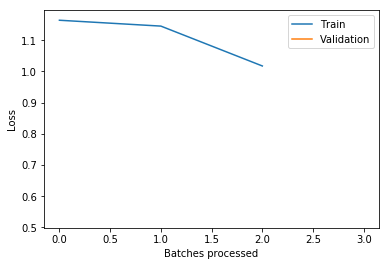

In [52]:
learn.recorder.plot_losses()

In [126]:
mdl = learn.model

In [127]:
# Load submission file
submission = pd.read_csv('data/sample_submission.csv', index_col='seg_id', dtype={"time_to_failure": np.float32})

# Load each test data, create the feature matrix, get numeric prediction
for i, seg_id in enumerate(tqdm(submission.index)):
#     print(i)
    seg = pd.read_csv('data/test/' + seg_id + '.csv')
    x = seg['acoustic_data'].values
    
    x, y = create_X(last_index=idx, n_steps=self.seq_len, step_length=1000)
    x = torch.tensor(create_X(x))[None,:,:].to(torch.device('cuda'))#.view(1,-1,:)
    pred = mdl(x).cpu().detach().numpy()[0]
    submission.time_to_failure[i] = pred
#     break

submission.head()

# # Save

# 

100%|██████████| 2624/2624 [00:59<00:00, 44.34it/s]


,time_to_failure
seg_id,
seg_00030f,5.424631
seg_0012b5,5.698467
seg_00184e,5.698063
seg_003339,5.692963
seg_0042cc,5.623507


In [128]:
submission.to_csv('submission.csv')